# sortsol

In [50]:
import syrkis

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
from evosax import OpenES

from functools import partial
from tqdm import tqdm
from typing import Callable, Tuple, List, Dict, Any, Optional
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
POPSIZE  = 50
LAYERS   = 3
HIDDEN   = 10
N_DRONES = 16
kernel   = jnp.ones((5, 5))[:, :, None, None]

In [52]:
# TYPES
Array = jnp.ndarray

In [53]:
def grid_positions(n_drones) -> Array:
    # n_drones is power of 2
    lo, hi = - int(n_drones ** 0.5), int(n_drones ** 0.5)
    span   = jnp.linspace(lo, hi, int(n_drones ** 0.5))
    x, y   = jnp.meshgrid(span, span)
    coords = jnp.stack([x.ravel(), y.ravel()], axis=1)
    return coords

def init_swarm(n_drones: int) -> Array:
    coords   = grid_positions(n_drones)
    velocity = jnp.zeros_like(coords)
    swarm    = jnp.concatenate([coords, velocity], axis=1)
    return swarm

def conv2d(x, w):
    return jax.lax.conv_general_dilated(x, w, window_strides=(1, 1),padding='SAME',dimension_numbers=("NHWC", "HWIO", "NHWC")).squeeze()

def positions(swarm: Array) -> Array:  # TODO: sort by distance (probably)
    delta        = swarm[:, :N_DRONES][:, jnp.newaxis] - swarm[:, :N_DRONES][jnp.newaxis, :]                      
    other_dists  = jnp.sqrt(jnp.sum(delta ** 2, axis=-1))                          # others
    other_theta  = jnp.arctan2(delta[..., 1], delta[..., 0])
    idx          = jnp.argsort(other_dists, axis=-1)[:, 1:]                        # sort others and remove self
    other_dists  = other_dists[jnp.arange(other_dists.shape[0])[:, None], idx]     # origin
    other_theta  = other_theta[jnp.arange(other_theta.shape[0])[:, None], idx]
    origin_dist  = jnp.sqrt(jnp.sum(swarm[:, :N_DRONES] ** 2, axis=-1))
    origin_theta = jnp.arctan2(swarm[:, :N_DRONES][..., 1], swarm[:, :N_DRONES][..., 0])
    return origin_theta, origin_dist, other_dists, other_theta

def act(rng, params, swarm: Array, momentum=0.6) -> Array:
    # swarm : n_drones x 4 (x, y, dx, dy)
    coords, velocity = jnp.split(swarm, 2, axis=1)
    new_coords       = coords + velocity
    obs              = observe(swarm)
    theta, speed     = model(rng, params, obs)  # n_drones x 2 (theta, speed)
    delta            = jnp.stack((speed * jnp.cos(theta), speed * jnp.sin(theta)), axis=1).squeeze()
    new_velocity     = momentum * speed + (1 - momentum) * delta
    new_velocity     = jax.nn.tanh(new_velocity)
    return jnp.concatenate([new_coords, new_velocity], axis=1)

def model(rng, params, obs) -> Array:
    # given an observation, predict the next action
    noise  = random.normal(rng, (obs.shape[0], 2)) * 0.01
    action = jnp.tanh(jnp.dot(obs, params) + noise)
    return jnp.split(action, 2, axis=1)

def loss_fn(image, dists):
    # minimise number of drones in the same pixel
    coverage_term  = 1 / jnp.sqrt(jnp.abs(dists)).mean()
    collision_term = jnp.log(1 / ((image.sum() + 1) / (N_DRONES * kernel.size)))
    return collision_term + coverage_term

def fitness_fn(genome, rng, n_steps=200) -> Array:
    swarm = init_swarm(N_DRONES)
    for i in range(n_steps):
        rng, key = random.split(rng)
        swarm    = act(key, genome, swarm)
        if i == n_steps - 1:
            image    = quantize(swarm)
            obs      = observe(swarm)
            dists    = jnp.split(obs, 2, axis=1)[0]
            return loss_fn(image, dists)

def observe(swarm: Array) -> Array:
    origin_theta, origin_dist, other_dists, other_theta = positions(swarm)
    thetas = jnp.concatenate([origin_theta[:, None], other_theta], axis=1)  # n_drones x 1 + n_drones
    dists  = jnp.concatenate([origin_dist[:, None], other_dists], axis=1)   # n_drones x 1 + n_drones
    obs    = jnp.concatenate([thetas, dists], axis=1)                       # n_drones x 2 + 2 * n_drones
    return obs

def resize(source, target):
    # make source have same dimensions as target (for plotting)
    return jax.image.resize(source, (target.shape[0], target.shape[1]), method='nearest')

def quantize(swarm: Array, resolution: int = 256) -> Array:
    coords = (jnp.split(swarm, 2, axis=1)[0] * int(10)).astype(int) + resolution // 2
    x, y   = jnp.split(coords, 2, axis=1)
    x, y   = x.squeeze(), y.squeeze()
    # remove coordinates not in bounds
    image  = jnp.zeros((resolution, resolution))
    mask   = (x >= 0) & (x < resolution) & (y >= 0) & (y < resolution)
    x, y   = x * mask, y * mask
    matrix = image.at[x, y].add(1)[None, ..., None]
    matrix = conv2d(matrix, kernel)
    return (matrix == 1).astype(int)


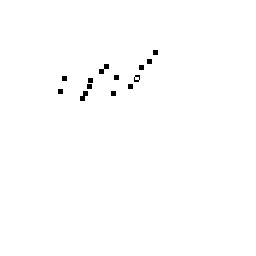
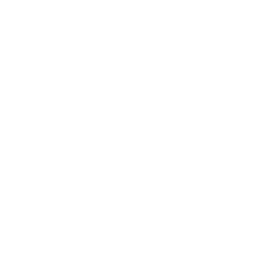
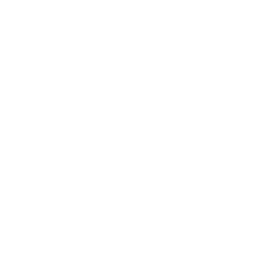

fitness: 6.507:  15%|█▌        | 15/100 [03:40<23:11, 16.37s/it]

In [54]:
def train():
    params    = jnp.zeros((N_DRONES * 2, 2))
    strategy  = OpenES(popsize=POPSIZE, pholder_params=params)   # for each drone, theta and speed of others, to theta and speed of self
    es_params = strategy.default_params
    rng, key  = random.split(random.PRNGKey(0))
    state     = strategy.initialize(key, es_params)
    inspect   = 3

    pbar = tqdm(range(100))
    for i in pbar:
        rng, key       = random.split(rng)
        genome, state  = strategy.ask(key, state, es_params)
        fitness        = vmap(fitness_fn, in_axes=(0, None))(genome, rng)
        pbar.set_description(f'fitness: {fitness.mean():.3f}')
        if i % 2 == 0:
            sorted_params = genome[fitness.argsort()]
            all_swarms = [init_swarm(N_DRONES) for _ in range(inspect)]
            all_params = [sorted_params[j] for j in range(0, len(sorted_params), len(sorted_params) // inspect)]
            for j in range(100):
                imgs = []
                losses = []
                for k in range(inspect):
                    rng, key = random.split(rng)
                    all_swarms[k] = act(key, all_params[k], all_swarms[k])
                    image = quantize(all_swarms[k])[..., None]
                    imgs.append(image)
                    obs = observe(all_swarms[k])
                    dists = jnp.split(obs, 2, axis=1)[0]
                    losses.append(loss_fn(image, dists))
                low_bar = [f'loss {i}: {losses[i]:.3f}' for i in range(inspect)]
                imgs = jnp.stack(imgs, axis=0)
                syrkis.plot.multiples(imgs, 1, inspect, low_bar=low_bar, invertable=True, top_bar=[f'generation {i}'])
train()

In [ ]:
swarm    = init_swarm(N_DRONES)
rng, key = random.split(random.PRNGKey(0))
obs      = observe(swarm)
params = - jnp.ones((N_DRONES * 2, 2))  

for i in range(50):
    rng, key = random.split(rng)
    # fitness  = fitness_fn(params, key)
    obs      = observe(swarm)
    dists    = jnp.split(obs, 2, axis=1)[0]
    swarm    = act(key, params, swarm)
    image    = quantize(swarm)
    loss     = loss_fn(image, dists)
    imgs     = jnp.stack([image[:, :, None], image[:, :, None], image[:, :, None]], axis=0)
    low_bar  = [f"loss: {loss:.3f}"]
    syrkis.plot.multiples(imgs, 1, 2, low_bar=low_bar, invertable=True)

In [ ]:
jnp.log(1 / ((image.sum() + 1) / (N_DRONES * kernel.size)))

In [ ]:
1 / jnp.abs(dists).mean()

In [ ]:
imgs.shape